In [ ]:
# The MIT License (MIT) Copyright (c) 2024 Andrés Urbano Andrea, Núñez Quintana Luis Axel & Ramírez Gómez María Emilia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_lstm.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning

## 0. Dependencias

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
from PIL import Image
import random
import time
import torch
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
import torchvision
import torchvision.models as models
from torchvision.models import efficientnet_b0
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision import transforms

torch.__version__

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

'2.3.0+cu121'

In [ ]:
torch.manual_seed(77)

## 1.- Dataset

In [ ]:
# Download dataset
if not os.path.exists('img'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: img/nikolai-ge_love-of-vestal.jpg  
  inflating: img/camille-corot_orpheus-leading-eurydice-from-the-underworld-1861.jpg  
  inflating: img/caspar-david-friedrich_easter-morning.jpg  
  inflating: img/konstantin-makovsky_beauty-preparing-to-bathe.jpg  
  inflating: img/john-everett-millais_the-royalist.jpg  
  inflating: img/pierre-paul-prud'hon_madame-simon.jpg  
  inflating: img/konstantin-makovsky_portrait-of-the-count-nikolay-muravyov-amursky.jpg  
  inflating: img/jean-leon-gerome_pifferari2.jpg  
  inflating: img/gustave-dore_daniel-confounds-the-priests-of-bel.jpg  
  inflating: img/john-crome_carrow-abbey-norwich-1805.jpg  
  inflating: img/nikolai-ge_death-of-virginia-study-1.jpg  
  inflating: img/gustave-dore_the-inferno-canto-32-1.jpg  
  inflating: img/john-constable_shoreham-bay-near-brighton-1824.jpg  
  inflating: img/william-turner_view-of-saint-germain-ea-laye-and-its-chateau.jpg  
  infla

In [ ]:
# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]
images['painting'] = images['painting'].apply(lambda x: 'img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


,painting,utterance
0,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,The scene is quite beautiful and reminds me of...
1,img/viktor-vasnetsov_ivan-tsarevich-riding-the...,There is a sense of romance between the two pe...
2,img/william-turner_fishermen-at-sea.jpg,"There is a spooky feel to this image, with the..."
3,img/william-turner_fishermen-at-sea.jpg,The boat makes a dangerous journey alone at ni...
4,img/paul-cezanne_the-oilmill-1871.jpg,The village looks very rudimentary with it's s...
5,img/n.c.-wyeth_merlin-taking-away-the-infant-a...,It looks like the baby is being taken for what...
6,img/orest-kiprensky_the-family-of-satyrs.jpg,The imps playfully dance and sing to the music.
7,img/sir-lawrence-alma-tadema_strigils-and-spon...,The women appear quite interested in one anoth...
8,img/orest-kiprensky_putto-with-a-globe.jpg,The little boy is trying to roll the globe aro...
9,img/sir-lawrence-alma-tadema_pleading-1876.jpg,The man laying down in this painting feels lik...


- Download images:

In [ ]:
# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
images = sorted(images, key = lambda x: x[0])
len(images)

39069

- Dataset split

In [ ]:
# split is made so that train and val dont have the same painting
num_val_samples = int(0.05 * len(images)) + 2
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
print(train_images[:1],val_images[-1:])
print(len(train_images), len(val_images))

[array(['img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg',
       'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting'],
      dtype=object)] [array(['img/arthur-hughes_the-beautiful-lady-without-pity-1863.jpg',
       'The look of two people in love.'], dtype=object)]
37114 1955


In [ ]:
def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36910, 1851)

In [ ]:
for tuple in train_tuples[:2]:
    print(tuple)

('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting')
('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'The mother face looks excited to hold her baby for the first time')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [ ]:
vocab_size = len(vocab)
vocab_size

16820

In [ ]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

- Reduce dataset size for simplicity

In [ ]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            [vocab[token] for token in tokenizer(y)],
            dtype=torch.long
        )

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))

    return data

train_data = data_process(train_tuples[:50000])
val_data = data_process(val_tuples[:1000])
len(train_data), len(val_data)

(35389, 961)

In [ ]:
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(
            torch.cat([
                torch.tensor([BOS_IDX]),
                y_item,
                torch.tensor([EOS_IDX])
            ], dim=0)
        )

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 31]), torch.Size([64, 31]))

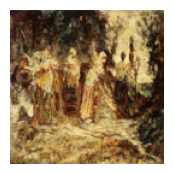

Ground truth: the bright colors and splashes of reds give this piece an energetic look , like the maidens in it are about to <unk> on a journey .    


In [ ]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[_] for _ in target]
    ).replace("<pad>", "").replace("<eos>", "")

    fig = plt.figure(figsize=(2, 2))

    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(f'Ground truth: {image_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [ ]:
class Pretrained(torch.nn.Module):
    def __init__(self):
        super(Pretrained, self).__init__()
        m = efficientnet_b0()
        self.body = create_feature_extractor(
            m, return_nodes={'features.5.0.block.0':'0'})
        inp = torch.randn(1, 3, 128, 128)
        with torch.no_grad():
            out = self.body(inp)
        in_channels_list = [o.shape[1] for o in out.values()]
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool())

    def forward(self, x):
        x = self.body(x)

        return x['0']

#model = Pretrained().eval()
#model(enc_batch).shape

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        #self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        #self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        #self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.Pretrained = Pretrained().eval()
        self.adapt = nn.Sequential(
            nn.Conv2d(480, 31, 3, bias=False, padding = 1, stride = 1)
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
      #features = self.inception(images)
      B = images.shape[0]
      y = self.Pretrained(images)
      print(y.shape)
      y = self.adapt(y)
      y = y.reshape(B, 64, 31).permute(0, 2, 1)
      print(y.shape)
      return y


      #features = self.relu(features)
      #features = self.dropout(features)
      #return y

    #  for name, param in self.inception.named_parameters():
    #    if "fc.weight" in name or "fc.bias" in name:
    #      param.requires_grad = True
    #    else:
    #      param.requires_grad = self.train_CNN

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        #embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        #features = features.view(-1, features.shape[0])
        print("feature:", features.shape)
        print("embedding:", embeddings.shape)
        #embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        embeddings = torch.cat((features, embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=150):
        result_caption = []

        with torch.no_grad():
          x = self.encoderCNN(image).unsqueeze(0)
          states = None

          for _ in range(max_length):
            hiddens, states = self.decoderRNN.lstm(x, states)
            output = self.decoderRNN.linear(hiddens.squeeze(0))
            predicted = output.argmax(1)

            result_caption.append(predicted.item())
            x = self.decoderRNN.embed(predicted).unsqueeze(0)

            if vocabulary.itos[predicted.item()] == '<EOS>':
              break

        return [vocabulary.itos[idx] for idx in result_caption]


#Hyperparameters
#embed_size = 256
embed_size = 64
hidden_size = 256
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

#CNNtoRNN
modelLSTM = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)


In [ ]:
output = modelLSTM(enc_batch, dec_batch)
output.shape

torch.Size([64, 480, 8, 8])
torch.Size([64, 31, 64])
feature: torch.Size([64, 31, 64])
embedding: torch.Size([64, 31, 64])


torch.Size([128, 31, 16820])

## 4.- Training

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

modelLSTM.to(device)

cpu


CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (Pretrained): Pretrained(
      (body): EfficientNet(
        (features): Module(
          (0): Conv2dNormActivation(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): Module(
            (0): Module(
              (block): Module(
                (0): Conv2dNormActivation(
                  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): SiLU(inplace=True)
                )
                (1): SqueezeExcitation(
                  (avgpool): AdaptiveAvgPool2d(output_size=1)
                  (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                  (fc2): Co

In [ ]:
#criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(modelLSTM.parameters(), lr=learning_rate)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [ ]:
print(enc_batch.shape)

torch.Size([64, 3, 128, 128])


In [ ]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]

            #loss = criterion(logits.reashape(-1, ), idx.reshape(-1))
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if vocab.get_itos()[idx_next] == '<eos>':
                break
            idx = torch.cat((idx, idx_next), dim=1)

    txt = " ".join(
        [vocab.get_itos()[_] for _ in idx[0]]
    )
    print(f'Generated text: {txt.replace("<bos>", "")}')


generate(modelLSTM, enc_batch[idx], device, maxlen)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1]

In [ ]:
epochs = 25

for epoch in range(epochs):
  train(modelLSTM, device, train_loader, optimizer, epoch)
  #generate(transformer, enc_batch[idx], device, maxlen)

- Test the model on validation images.

In [ ]:
for i in range(0, 64, 5):
  idx = i
  plot_img(enc_batch[idx], target_batch[idx])
  generate(modelLSTM, enc_batch[idx], device, maxlen)